In [9]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats

In [10]:
import pandas as pd

# Wczytanie danych z pliku, bez nagłówków
fuel_path = 'fuel_5.csv'
fuel_df = pd.read_csv(fuel_path, header=None)

# Dostosowanie nagłówków do liczby kolumn
if fuel_df.shape[1] == 6:
    fuel_df.columns = ['Date', 'Price', 'Close', 'High', 'Low', 'Open']
elif fuel_df.shape[1] == 7:
    fuel_df.columns = ['Date', 'Price', 'Close', 'High', 'Low', 'Open', 'Volume']

# Usunięcie pierwszych dwóch wierszy, które zawierają nieprawidłowe dane
fuel_df = fuel_df.drop([0, 1])

# Usunięcie pierwszego wiersza w każdej kolumnie, który zawiera błędne dane
fuel_df = fuel_df.iloc[1:].reset_index(drop=True)

# Konwersja kolumny 'Date' na typ datetime
fuel_df['Date'] = pd.to_datetime(fuel_df['Date'])

# Sortowanie danych po dacie w odwrotnej kolejności (od najnowszej do najstarszej)
fuel_df = fuel_df.sort_values(by='Date', ascending=False).reset_index(drop=True)

# Sprawdzanie wyników
print(fuel_df.head())

        Date               Price               Close                High   
0 2025-04-04   2.054500102996826   2.159899950027466   2.006500005722046  \
1 2025-04-03   2.164299964904785   2.302500009536743   2.139699935913086   
2 2025-04-02  2.3310000896453857  2.3447000980377197  2.2934999465942383   
3 2025-04-01   2.302500009536743   2.311199903488159   2.281100034713745   
4 2025-03-31   2.283099889755249   2.286099910736084   2.232800006866455   

                  Low    Open  
0  2.1528000831604004   78450  
1   2.302500009536743  103855  
2  2.3018999099731445   82128  
3  2.2880001068115234   70882  
4  2.2346999645233154   65925  


In [11]:
# Konwersja kolumny 'Date' na typ datetime (jeśli jeszcze nie była)
fuel_df['Date'] = pd.to_datetime(fuel_df['Date'])

# Sortowanie danych po dacie malejąco
fuel_df = fuel_df.sort_values(by='Date', ascending=False).reset_index(drop=True)

# Sprawdzenie braków przed interpolacją
print("Braki przed interpolacją:\n", fuel_df.isna().sum())

# Interpolacja tylko na kolumnach liczbowych
numeric_cols = fuel_df.select_dtypes(include='number').columns
fuel_df[numeric_cols] = fuel_df[numeric_cols].interpolate(method='linear', limit_direction='forward', axis=0)

# Ucięcie lub dopasowanie do dokładnie 252 wierszy
fuel_df = fuel_df.head(252*5).reset_index(drop=True)

# Sprawdzenie braków po interpolacji
print("Braki po interpolacji:\n", fuel_df.isna().sum())
print(f"Liczba wierszy po obróbce: {len(fuel_df)}")

Braki przed interpolacją:
 Date     0
Price    0
Close    0
High     0
Low      0
Open     0
dtype: int64
Braki po interpolacji:
 Date     0
Price    0
Close    0
High     0
Low      0
Open     0
dtype: int64
Liczba wierszy po obróbce: 1259


In [13]:
print(fuel_df.columns)


Index(['Date', 'Price', 'Close', 'High', 'Low', 'Open'], dtype='object')


In [14]:
# Zostaw tylko Date i fuel_data, zmień nazwę kolumny
fuel_df = fuel_df[['Date', 'Close']]

# Konwersja na float (ważne!)
fuel_df['Close'] = pd.to_numeric(fuel_df['Close'], errors='coerce')

# Stworzenie ramki z datami
main_dates = pd.DataFrame({'Date': fuel_df['Date']})

# Dołączenie danych fuel
merged = main_dates.merge(fuel_df, on='Date', how='left')

# Interpolacja brakujących danych
merged['Close'] = merged['Close'].interpolate(method='linear')

# Obliczenie logarytmicznej stopy zwrotu
merged['logret_fuel_data'] = np.log(merged['Close'] / merged['Close'].shift(1))

# Zapis do pliku CSV z separatorem średnikowym
merged.to_csv('fuel_5_output.csv', index=False, sep=';')

print("Zapisano plik 'fuel_output.csv'.")

Zapisano plik 'fuel_output.csv'.


C:\Users\User\AppData\Local\Temp\ipykernel_16664\3028175443.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fuel_df['Close'] = pd.to_numeric(fuel_df['Close'], errors='coerce')


Parametry rozkładu Gumbela: μ = 4.4965, β = 1.3363


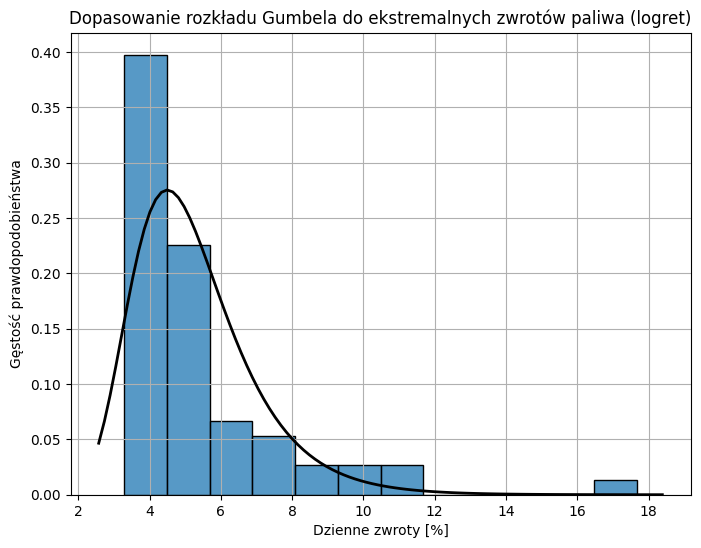

In [24]:
# Przeliczamy logret_fuel na procenty, żeby wartości były bardziej czytelne
import seaborn as sns

fuel_df = pd.read_csv("fuel_5_output.csv",sep=";")
dates = fuel_df['Date']
fuel_data = fuel_df['fuel_data']
logret_fuel_data=fuel_df['logret_fuel_data']

daily_returns_percent = logret_fuel_data * 100

# 95. percentyl – granica wartości ekstremalnych
threshold = np.percentile(daily_returns_percent.dropna(), 95)

# Ekstremalne wartości powyżej progu
extreme_values = daily_returns_percent[daily_returns_percent > threshold]

# Dopasowanie rozkładu Gumbela
params = stats.gumbel_r.fit(extreme_values)

# Wypisanie parametrów
print(f"Parametry rozkładu Gumbela: μ = {params[0]:.4f}, β = {params[1]:.4f}")

# Rysowanie histogramu + gęstość rozkładu Gumbela
plt.figure(figsize=(8, 6))
#plt.hist(extreme_values, bins=30, density=True, alpha=0.6, color='green')

sns.histplot(extreme_values,stat='density', bins = 12, label='Empiryczne maksima')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.gumbel_r.pdf(x, *params)

plt.plot(x, p, 'k', linewidth=2)
plt.title("Dopasowanie rozkładu Gumbela do ekstremalnych zwrotów paliwa (logret)")
plt.xlabel("Dzienne zwroty [%]")
plt.ylabel("Gęstość prawdopodobieństwa")
plt.grid(True)
plt.show()


Parametry rozkładu GEV: shape (ξ) = -0.5523, loc = 4.1722, scale = 0.9060


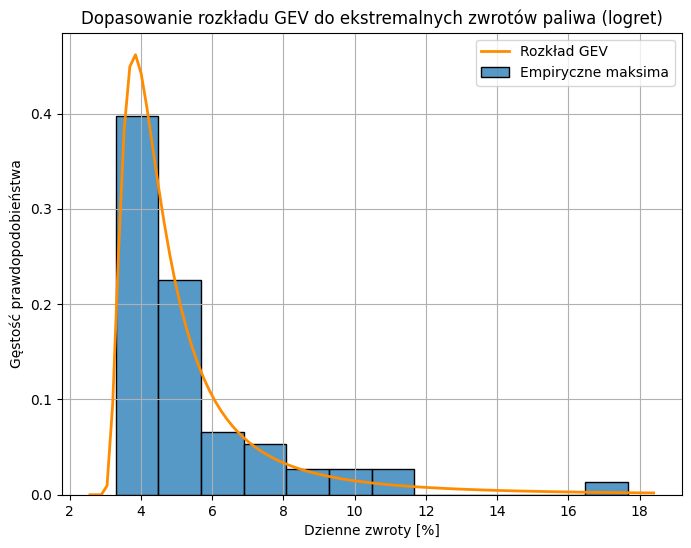

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Wczytanie danych
fuel_df = pd.read_csv("fuel_5_output.csv", sep=";")
logret_fuel_data = fuel_df['logret_fuel_data']
daily_returns_percent = logret_fuel_data * 100

# Ekstremalne wartości powyżej 95 percentyla
threshold = np.percentile(daily_returns_percent.dropna(), 95)

'''
Q1 = np.percentile(daily_returns_percent.dropna(), 25)
Q3 = np.percentile(daily_returns_percent.dropna(), 75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR
'''
# Wartości ekstremalne powyżej progu IQR
extreme_values = daily_returns_percent[daily_returns_percent > threshold]
# Dopasowanie rozkładu GEV
params = stats.genextreme.fit(extreme_values)

# Wypisanie parametrów rozkładu GEV
shape, loc, scale = params
print(f"Parametry rozkładu GEV: shape (ξ) = {shape:.4f}, loc = {loc:.4f}, scale = {scale:.4f}")

# Rysowanie histogramu i PDF rozkładu GEV
plt.figure(figsize=(8, 6))
sns.histplot(extreme_values, stat='density', bins=12, label='Empiryczne maksima')

# PDF rozkładu GEV
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf = stats.genextreme.pdf(x, shape, loc=loc, scale=scale)

plt.plot(x, pdf, 'darkorange', lw=2, label='Rozkład GEV')
plt.title("Dopasowanie rozkładu GEV do ekstremalnych zwrotów paliwa (logret)")
plt.xlabel("Dzienne zwroty [%]")
plt.ylabel("Gęstość prawdopodobieństwa")
plt.grid(True)
plt.legend()
plt.show()


Parametry rozkładu Pareto: shape (α) = 6.9417, loc = -12.6556, scale = 12.6557


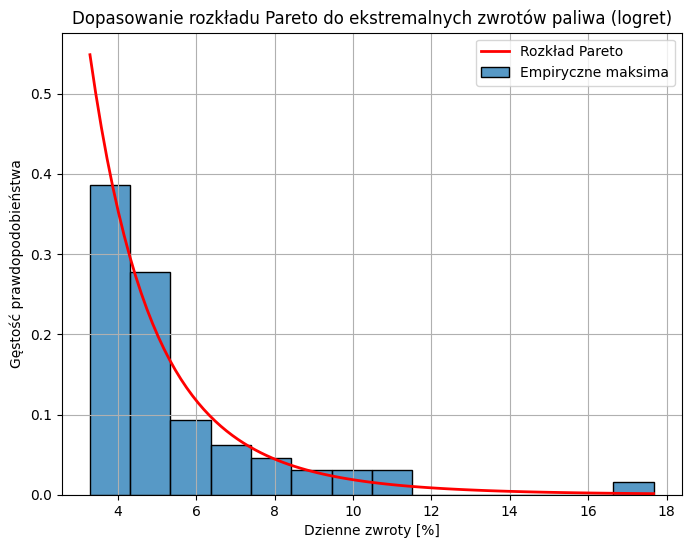

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Wczytanie danych
fuel_df = pd.read_csv("fuel_5_output.csv", sep=";")
logret_fuel_data = fuel_df['logret_fuel_data']
daily_returns_percent = logret_fuel_data * 100

# Wybieramy wartości ekstremalne (np. górne 5%)
threshold = np.percentile(daily_returns_percent.dropna(), 95)
extreme_values = daily_returns_percent[daily_returns_percent > threshold]

# Aby dopasować rozkład Pareto, dane muszą być dodatnie i większe niż minimalna wartość > 0
# Przesuwamy dane, żeby były > 0 (bo pareto jest zdefiniowane na (xmin, ∞))
shift = extreme_values.min() - 0.0001  # delikatne przesunięcie, żeby minimum nie było dokładnie 0
extreme_shifted = extreme_values - shift

# Dopasowanie rozkładu Pareto
params = stats.pareto.fit(extreme_shifted)

# Wypisanie parametrów rozkładu Pareto
print(f"Parametry rozkładu Pareto: shape (α) = {params[0]:.4f}, loc = {params[1]:.4f}, scale = {params[2]:.4f}")

# Rysowanie histogramu i dopasowanego rozkładu Pareto
plt.figure(figsize=(8, 6))
sns.histplot(extreme_values, stat='density', bins=14, label='Empiryczne maksima')

# PDF rozkładu Pareto
xmin, xmax = plt.xlim()
x = np.linspace(extreme_values.min(), extreme_values.max(), 100)
x_shifted = x - shift
pdf = stats.pareto.pdf(x_shifted, *params)

plt.plot(x, pdf, 'r', lw=2, label='Rozkład Pareto')
plt.title("Dopasowanie rozkładu Pareto do ekstremalnych zwrotów paliwa (logret)")
plt.xlabel("Dzienne zwroty [%]")
plt.ylabel("Gęstość prawdopodobieństwa")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from scipy.stats import genextreme
import seaborn as sns

L = gaz_ext_pln.values[gaz_ext_pln.values > 0]

block_size = 7
num_blocks = len(L) // block_size
blocks = L[:num_blocks * block_size].reshape(num_blocks, block_size)
M = blocks.max(axis=1)

gev_params = genextreme.fit(M)  # shape, loc, scale
shape_gev, loc_gev, scale_gev = gev_params

x = np.linspace(min(M), max(M), 100)
gev_pdf = genextreme.pdf(x, *gev_params)

plt.figure(figsize=(10, 5))
sns.histplot(M, stat='density', bins = 10, label='Empiryczne maksima')
plt.plot(x, gev_pdf, 'r-', lw=2, label='Dopasowany rozkład GEV')
plt.title('Dopasowanie rozkładu GEV do maksimów')
plt.xlabel('zmiana')
plt.ylabel('gęstość prawdopodobieństwa')
plt.legend()
plt.grid(True)
plt.show()

gev_params